# SETUP

In [21]:
# TA-LIB
!wget https://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
!tar -xzf ta-lib-0.4.0-src.tar.gz
%cd ta-lib/
!./configure --prefix=/usr
!make
!sudo make install
%cd /content


--2022-09-07 19:42:55--  https://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|204.68.111.105|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://altushost-swe.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-09-07 19:42:57--  https://altushost-swe.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving altushost-swe.dl.sourceforge.net (altushost-swe.dl.sourceforge.net)... 79.142.76.130
Connecting to altushost-swe.dl.sourceforge.net (altushost-swe.dl.sourceforge.net)|79.142.76.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1330299 (1.3M) [application/x-gzip]
Saving to: ‘ta-lib-0.4.0-src.tar.gz’

ta-lib-0.4.0-src.ta   6%[>                   ]  79.76K  --.-KB/s    in 81s     

20

In [22]:
!pip install backtrader matplotlib==3.2.2 seaborn TA-Lib hyperopt backtrader-plotting

^C
Traceback (most recent call last):
  File "/workspace/habr/jeezy/.venv/bin/pip", line 5, in <module>
    from pip._internal.cli.main import main
  File "/workspace/habr/jeezy/.venv/lib/python3.9/site-packages/pip/_internal/cli/main.py", line 9, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/workspace/habr/jeezy/.venv/lib/python3.9/site-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/workspace/habr/jeezy/.venv/lib/python3.9/site-packages/pip/_internal/cli/main_parser.py", line 8, in <module>
    from pip._internal.cli import cmdoptions
  File "/workspace/habr/jeezy/.venv/lib/python3.9/site-packages/pip/_internal/cli/cmdoptions.py", line 23, in <module>
    from pip._internal.cli.parser import ConfigOptionParser
  File "/workspace/habr/jeezy/.venv/lib/python3.9/site-packages/pip/_internal/cli/parser.py", line 12, in <module>
    from pip._internal.configura

In [11]:
import timeit
import sys
import datetime
import time
import re
import glob
from functools import partial

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import pandas as pd

import talib
import pandas_ta as ta
import numpy as np

import backtrader as bt  # Import the backtrader platform
from backtrader_plotting import Bokeh

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval

import requests
import json
import numpy as np

IS_IN_COLAB = 'google.colab' in sys.modules
if not IS_IN_COLAB:
    pd.set_option('display.max_columns', 50)
    pd.set_option('display.width', 150)
    pd.set_option('display.max_rows', 250)


# BASE PARAMETERS


In [12]:
#@title TICKET AND DATAFRAME

TICKER = "BTCUSDT" #@param {type:"string"}
TIME_FRAME = "15m" #@param {type:"string"}
FROM_DATE = "2022-08-01" #@param {type:"string"}
MONEY_START = 100000 #@param {type:"integer"}
COMMISSION_PRST = 0.1 #@param {type:"number"}
COMMISSION = COMMISSION_PRST / 100

In [13]:
# OPTIMIZATION PARAMETERS
OPTIM_TYPE ='Annealing' #@param ['Annealing']
OPTIM_PARAMETER = 'net_profit' #@param ['net_profit']
# OPTIM_PARAMETER ='Equity Final [$]' #@param ['Equity Final [$]', 'Return [%]', 'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 'Win Rate [%]', 'Profit Factor']
OPTIM_ITERATION = 100 #@param {type:"integer"}

In [14]:
# Setting the parameter space
#@title The range of parameters to be checked: INDICATORS

# Supetrend
#@markdown ST Period (default: 14)
SHOULD_USE_FAST_MA_PERIOD = True #@param {type:"boolean"}
FAST_MA_LEN_FROM = 2 #@param {type:"integer"}
FAST_MA_LEN_TO = 25 #@param {type:"integer"}
#@markdown ST Factor (default: 2)
SHOULD_USE_SLOW_MA = True #@param {type:"boolean"}
SLOW_MA_LEN_FROM = 3  #@param {type:"integer"}
SLOW_MA_LEN_TO = 50 #@param {type:"integer"}


### AFTER CHANGES DEMAND TO RECALCULATE PARAMETER SPACE IN CELL BELLOW

In [15]:
def get_range_arr(val_from, val_to, mult=None):
  if(mult):
    return [val * mult for val in range(val_from, val_to + 1)]
  return [val for val in range(val_from, val_to + 1)]

def get_float_range_arr(val_from, val_to, mult=0.1):
  return [val * mult for val in range(int(val_from/mult), int(val_to/mult) + 1)]

base_param = {
    'stake': 2, #
    'commission': COMMISSION,
    'money_start': MONEY_START,
    'slip_perc': 0.005, # TODO Slippage https://www.backtrader.com/docu/slippage/slippage/
    'StartDateTime': FROM_DATE,  # Start Time
    'EndDateTime': None  # End Time
}

search_space = {}
if OPTIM_TYPE == 'Annealing':
    search_space = {}
if SHOULD_USE_FAST_MA_PERIOD:
   if OPTIM_TYPE == 'Annealing':
        search_space['p_fast'] = hp.choice('Fast Len', get_range_arr(FAST_MA_LEN_FROM, FAST_MA_LEN_TO, 1))

if SHOULD_USE_SLOW_MA:
   if OPTIM_TYPE == 'Annealing':
        search_space['p_slow'] = hp.choice('Low Len', get_range_arr(SLOW_MA_LEN_FROM, SLOW_MA_LEN_TO, 1))


search_space

{'p_fast': <hyperopt.pyll.base.Apply at 0x7f86864725b0>,
 'p_slow': <hyperopt.pyll.base.Apply at 0x7f8685c02c40>}

# GET DATA


In [16]:
# init data, also can parse files that exported from tradingview

FN_TICKERS_REGEXP = f'({TICKER}\,\s*{TIME_FRAME}\.csv$)|({TICKER}_{TIME_FRAME}.csv$)'
all_dir = glob.glob('./*.csv', recursive=False) + glob.glob('./data/*.csv', recursive=False)
files_for_ticker = [fn for fn in all_dir if re.search(FN_TICKERS_REGEXP, fn, re.I)]
is_data_has_volume = True

max_val = 0

if files_for_ticker:
    datapath = files_for_ticker[0]
    df = pd.read_csv(datapath, header=0, encoding='utf-8', sep=',')
    df['time'] = pd.to_datetime(df['time'], unit='s')
    is_data_has_volume = 'volume' in df.columns
    df_filtered = df[df['time'] > pd.to_datetime(FROM_DATE)]
    df = df_filtered.reset_index().set_index('time')
else:
    from_date_val = datetime.datetime.fromisoformat(FROM_DATE)
    start_time = int(from_date_val.timestamp() * 1000)

    df = pd.DataFrame(columns=['time', 'open', 'high', 'low', 'close', 'volume'])
    opentime, lopen, lhigh, llow, lclose, lvol, closetime = [], [], [], [], [], [], []

    cur_time = datetime.datetime.utcnow().replace(minute=0, second=0, microsecond=0)
    cur_time = int(cur_time.timestamp()) * 1000 - 1

    if 'perp' in TICKER.lower():
        api_url = f'https://fapi.binance.com/fapi/v1/continuousKlines?pair={TICKER[:-len("perp")]}&interval={TIME_FRAME.lower()}&contractType=PERPETUAL&limit=1000'
    else:
        api_url = f'https://fapi.binance.com/fapi/v1/klines?symbol={TICKER}&interval={TIME_FRAME.lower()}&limit=1000'
    while start_time < cur_time:
        print(f'Get 1000 candles for {TICKER}:{TIME_FRAME} from the datetime {datetime.datetime.utcfromtimestamp(int(start_time / 1000))}')
        sym_info = requests.get(f"{api_url}&startTime={start_time}")
        if (sym_info.status_code == 429):
            raise InterruptedError(f'Limits is violated')
        elif (sym_info.status_code != 200):
            raise InterruptedError(f'Error for request. Code {sym_info.status_code}')
        candles = json.loads(sym_info.text)
        for candle in candles:
            opentime.append(candle[0])
            lopen.append(candle[1])
            lhigh.append(candle[2])
            llow.append(candle[3])
            lclose.append(candle[4])
            lvol.append(candle[5])
            closetime.append(candle[6])
        start_time = closetime[-1]
        time.sleep(0.25)

    df['open_time'] = pd.to_datetime(opentime, unit='ms', origin='unix')
    df['time'] = df['open_time'].apply(lambda x: int(x.timestamp()))
    df['open'] = np.array(lopen).astype(float)
    df['high'] = np.array(lhigh).astype(float)
    df['low'] = np.array(llow).astype(float)
    df['close'] = np.array(lclose).astype(float)
    df['volume'] = np.array(lvol).astype(float)
    df.to_csv(f'./{TICKER}, {TIME_FRAME}.csv', header=True, index=False, date_format='%s', encoding='utf-8',
              sep=',')
    df['time'] = df['open_time']
    df.set_index('time', inplace=True)
    # max_val = df['high'].max()
    is_data_has_volume = 'volume' in df.columns
    # data = TVPandasData(dataname=df, name=TICKER.lower())

max_val = df['high'].max()

class TVPandasData(bt.feeds.PandasData):
    params = (
        ('datetime', None),
        ('open', 'open'),
        ('high', 'high'),
        ('low', 'low'),
        ('close', 'close'),
        ('volume', 'volume' if is_data_has_volume else None),
        ('openinterest', None),
    )
data = TVPandasData(dataname=df, name=TICKER.lower())



# Base strategy parameters


In [17]:

base_param = {
    'stake': 2, #  Calculate from persentage of LongQtyPrcnt, Now it 50%
    'commission': COMMISSION,
    'money_start': max_val * 10 if max_val != 0 else 1000000,
    'slip_perc': 0.005, # TODO Slippage https://www.backtrader.com/docu/slippage/slippage/
    'StartDateTime': FROM_DATE,  # Start Time
    'EndDateTime': None  # End Time
}



# Strategy

In [22]:
class MAcrossover(bt.Strategy):
    # Moving average parameters
    params = (('p_fast', 10), ('p_slow', 20),)

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        # print(f'{len(self)} {dt.isoformat()} {txt}')  # Comment this line when running optimization

    def __init__(self):
        self.dataclose = self.datas[0].close

        # Order variable will contain ongoing order details/status
        self.order = None

        # Instantiate moving averages
        self.slow_sma = bt.ind.MovingAverageSimple(self.datas[0],
                                                   period=self.params.p_slow)
        self.fast_sma = bt.ind.MovingAverageSimple(self.datas[0],
                                                   period=self.params.p_fast)

        self.crossover = bt.ind.CrossOver(self.fast_sma, self.slow_sma)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # An active Buy/Sell order has been submitted/accepted - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            # if order.isbuy():
            #     self.log(f'BUY EXECUTED, {order.executed.price:.2f}')
            # elif order.issell():
            #     self.log(f'SELL EXECUTED, {order.executed.price:.2f}')
            self.bar_executed = len(self)

        # elif order.status in [order.Canceled, order.Margin, order.Rejected]:
        #     self.log('Order Canceled/Margin/Rejected')

        # Reset orders
        self.order = None

    def next(self):
        # Check for open orders
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            # We are not in the market, look for a signal to OPEN trades

            # If the 20 SMA is above the 50 SMA
            if self.crossover > 0:  # Fast ma crosses above slow ma
                # if self.fast_sma[0] > self.slow_sma[0] and self.fast_sma[-1] < self.slow_sma[-1]:
                # self.log(f'BUY CREATE {self.dataclose[0]:2f}')
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()
            # Otherwise if the 20 SMA is below the 50 SMA
            elif self.crossover < 0:  # Fast ma crosses below slow ma
                # elif self.fast_sma[0] < self.slow_sma[0] and self.fast_sma[-1] > self.slow_sma[-1]:
                # self.log(f'SELL CREATE {self.dataclose[0]:2f}')
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
        else:
            # We are already in the market, look for a signal to CLOSE trades
            if len(self) >= (self.bar_executed + 5):
                # self.log(f'CLOSE CREATE {self.dataclose[0]:2f}')
                self.order = self.close()

    # def stop(self):
    #     self.log(
    #         f'(MA Period fast: {self.params.pfast}, MA Period slow: {self.params.pslow}  Ending Value {self.broker.getvalue()}')




# Backtester functions


In [25]:
def get_cerebro(data, base_param, vp):
    cerebro = bt.Cerebro(optreturn=True, preload=True, runonce=True)
    cerebro.adddata(data)

    # TODO only need analyzer that used for strategy optimization(!)
    cerebro.addsizer(bt.sizers.FixedSize, stake=base_param['stake'])
    # cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    cerebro.addstrategy(MAcrossover, **vp)
    cerebro.broker = bt.brokers.BackBroker(cash=base_param['money_start'],
                                           slip_perc=base_param['slip_perc'])
    cerebro.broker.setcommission(commission=base_param['commission'])

    return cerebro

def runStrategy(data, base_param, vp):
    cerebro = get_cerebro(data, base_param, vp)
    stats = cerebro.run()
    net_profit = round(cerebro.broker.get_value() - base_param['money_start'], 2)
    # sharp =  stats[0].analyzers.sharpe_ratio.get_analysis() # -(stats[0].analyzers.sharpe_ratio.get_analysis()),
    # cerebro.plot(style='candlestick')

    # sharpe = stats[0].analyzers.sharpe_ratio.get_analysis()
    # drawdown = stats[0].analyzers.drawdown.get_analysis()
    trades = stats[0].analyzers.trades.get_analysis()
    # AnnualReturn = strategy.analyzers.AnnualReturn.get_analysis() # Calmar = strategy.analyzers.Calmar.get_analysis() # DrawDown = strategy.analyzers.DrawDown.get_analysis()
    stats_res = {
        'net_profit': net_profit,
        'profit': cerebro.broker.get_value(),
        'profit_rate': round(net_profit / base_param['money_start'] * 100, 2),
        # 'sharpe': sharpe['sharperatio'],
        # 'drawdown': drawdown['drawdown'], # max.moneydown # https://www.backtrader.com/docu/analyzers-reference/#drawdown
        # 'drawdown_money': drawdown['moneydown'],
        # 'drawdown_len': drawdown['len'],
        # 'drawdown_max': drawdown['max']['drawdown'],
        # 'drawdown_max_money': drawdown['max']['moneydown'],
        # 'trades_total': stats[0].wintrades[-1] + stats[0].losstrades[-1] + stats[0].eventrades[-1],
        # 'trades_win': stats[0].wintrades[-1],
        # 'trades_loss': stats[0].losstrades[-1] + stats[0].eventrades[-1]
        'trades_total': trades['total']['total'] # https://www.backtrader.com/docu/analyzers-reference/#tradeanalyzer
        }
    del cerebro
    del stats

    return {
        'loss': -(net_profit),
        'status': STATUS_OK,
        'stats': stats_res,
        'params': vp
    }


# RUN STRATEGY


In [26]:
%%time
if OPTIM_TYPE == 'Annealing':
    print('Attention\n. Resulting values shows in "best loss" with negative sign (need it for selected optimization method  which uses search for minimum values).')
    trials = Trials()
    partialRunStrategy = partial(runStrategy, data, base_param)
    best = fmin(fn=partialRunStrategy, space=search_space, algo=tpe.suggest, max_evals=OPTIM_ITERATION, trials=trials, show_progressbar=True)

Attention
. Resulting values shows in "best loss" with negative sign (need it for selected optimization method  which uses search for minimum values).
100%|██████████| 100/100 [04:19<00:00,  2.60s/trial, best loss: 6468.47]
CPU times: user 4min 8s, sys: 537 ms, total: 4min 9s
Wall time: 4min 19s


In [28]:
if OPTIM_TYPE == 'Annealing':
    best_param = space_eval(search_space, best)
    cerebro = get_cerebro(data, base_param, best_param)
    stats = cerebro.run()
stats




In [29]:
if OPTIM_TYPE == 'Annealing':
    best_param = space_eval(search_space, best)
    df_best_res = pd.Series(best_param, name='The best combination of parameters')
    print('Optimal parameters for strategy:')
    print(df_best_res)


Optimal parameters for strategy:
p_fast    22
p_slow    47
Name: The best combination of parameters, dtype: int64


In [43]:
if OPTIM_TYPE == 'Annealing':
    runs_res = [dict(list(res['stats'].items()) + list(res['params'].items())) for res in trials.results]
    heatmap = pd.DataFrame(runs_res)
    if(OPTIM_PARAMETER in heatmap.columns):
        sorted_res = heatmap.sort_values(OPTIM_PARAMETER, ascending=False)
        # sorted_res.to_csv(f'./res_{TICKER}_{TIME_FRAME}', header=True, index=False, encoding='utf-8', sep=',')
    else:
        sorted_res =  heatmap
    if not IS_IN_COLAB:
        print(sorted_res)
    else:
        sorted_res



    net_profit       profit  profit_rate  trades_total  p_fast  p_slow
78    -6468.47  245531.5310        -2.57           101      22      47
80    -6468.47  245531.5310        -2.57           101      22      47
81    -6468.47  245531.5310        -2.57           101      22      47
82    -6468.47  245531.5310        -2.57           101      22      47
86    -6468.47  245531.5310        -2.57           101      22      47
84    -6468.47  245531.5310        -2.57           101      22      47
83    -6468.47  245531.5310        -2.57           101      22      47
74    -6718.62  245281.3848        -2.67           107      22      46
76    -6718.62  245281.3848        -2.67           107      22      46
79    -6718.62  245281.3848        -2.67           107      22      46
68    -7404.75  244595.2482        -2.94            97      23      49
7     -7404.75  244595.2482        -2.94            97      23      49
66    -7404.75  244595.2482        -2.94            97      23      49
65    

In [44]:
if OPTIM_TYPE == 'Annealing':
    if IS_IN_COLAB:
        b = Bokeh(style='bar', plot_mode='single')
        cerebro.plot(b, volume=is_data_has_volume)
    else:
        cerebro.plot(style='candlestick', iplot=False)

ImportError: cannot import name 'warnings' from 'matplotlib.dates' (/workspace/TRADING/trade-strategies-optimization/.venv/lib/python3.9/site-packages/matplotlib/dates.py)

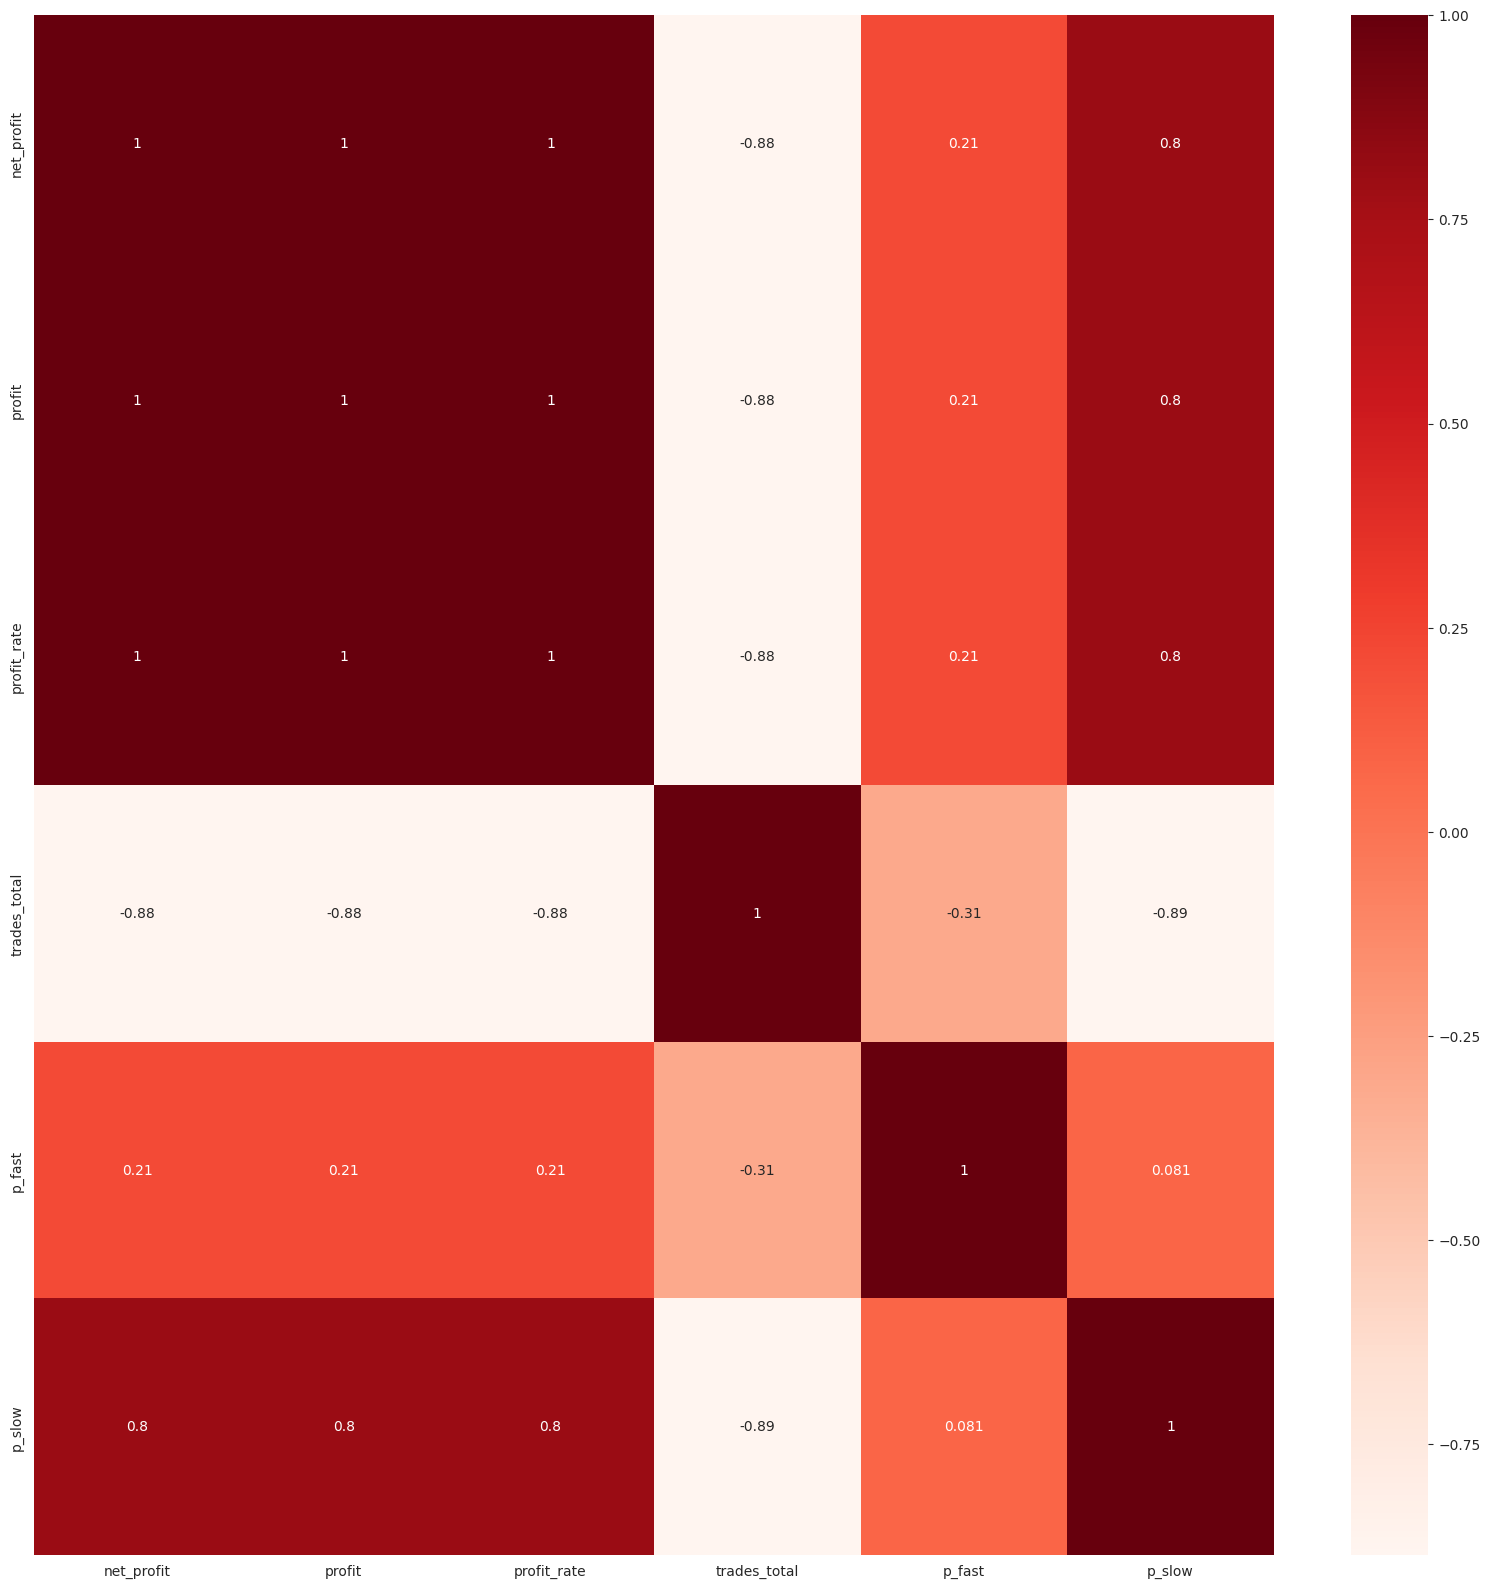

The most correlating parameters with profit:
p_slow    0.802752
p_fast    0.214438
Name: net_profit, dtype: float64


In [47]:
if  OPTIM_TYPE == 'Annealing':
    cor = heatmap.corr()
    matplotlib.pyplot.figure(figsize=(20, 20))
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()
    cor_target = cor[OPTIM_PARAMETER].abs()
    relevant_features = cor_target[[i in best_param.keys() for i in cor_target.index]].sort_values(ascending=False)
    print('The most correlating parameters with profit:')

    name_x = relevant_features.index[0]
    name_y = relevant_features.index[1]
    if not IS_IN_COLAB:
        print(relevant_features)
    relevant_features

/tmp/ipykernel_356525/3302473066.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax_plt = fig_plt.gca(projection='3d')
/tmp/ipykernel_356525/3302473066.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_plt.show()


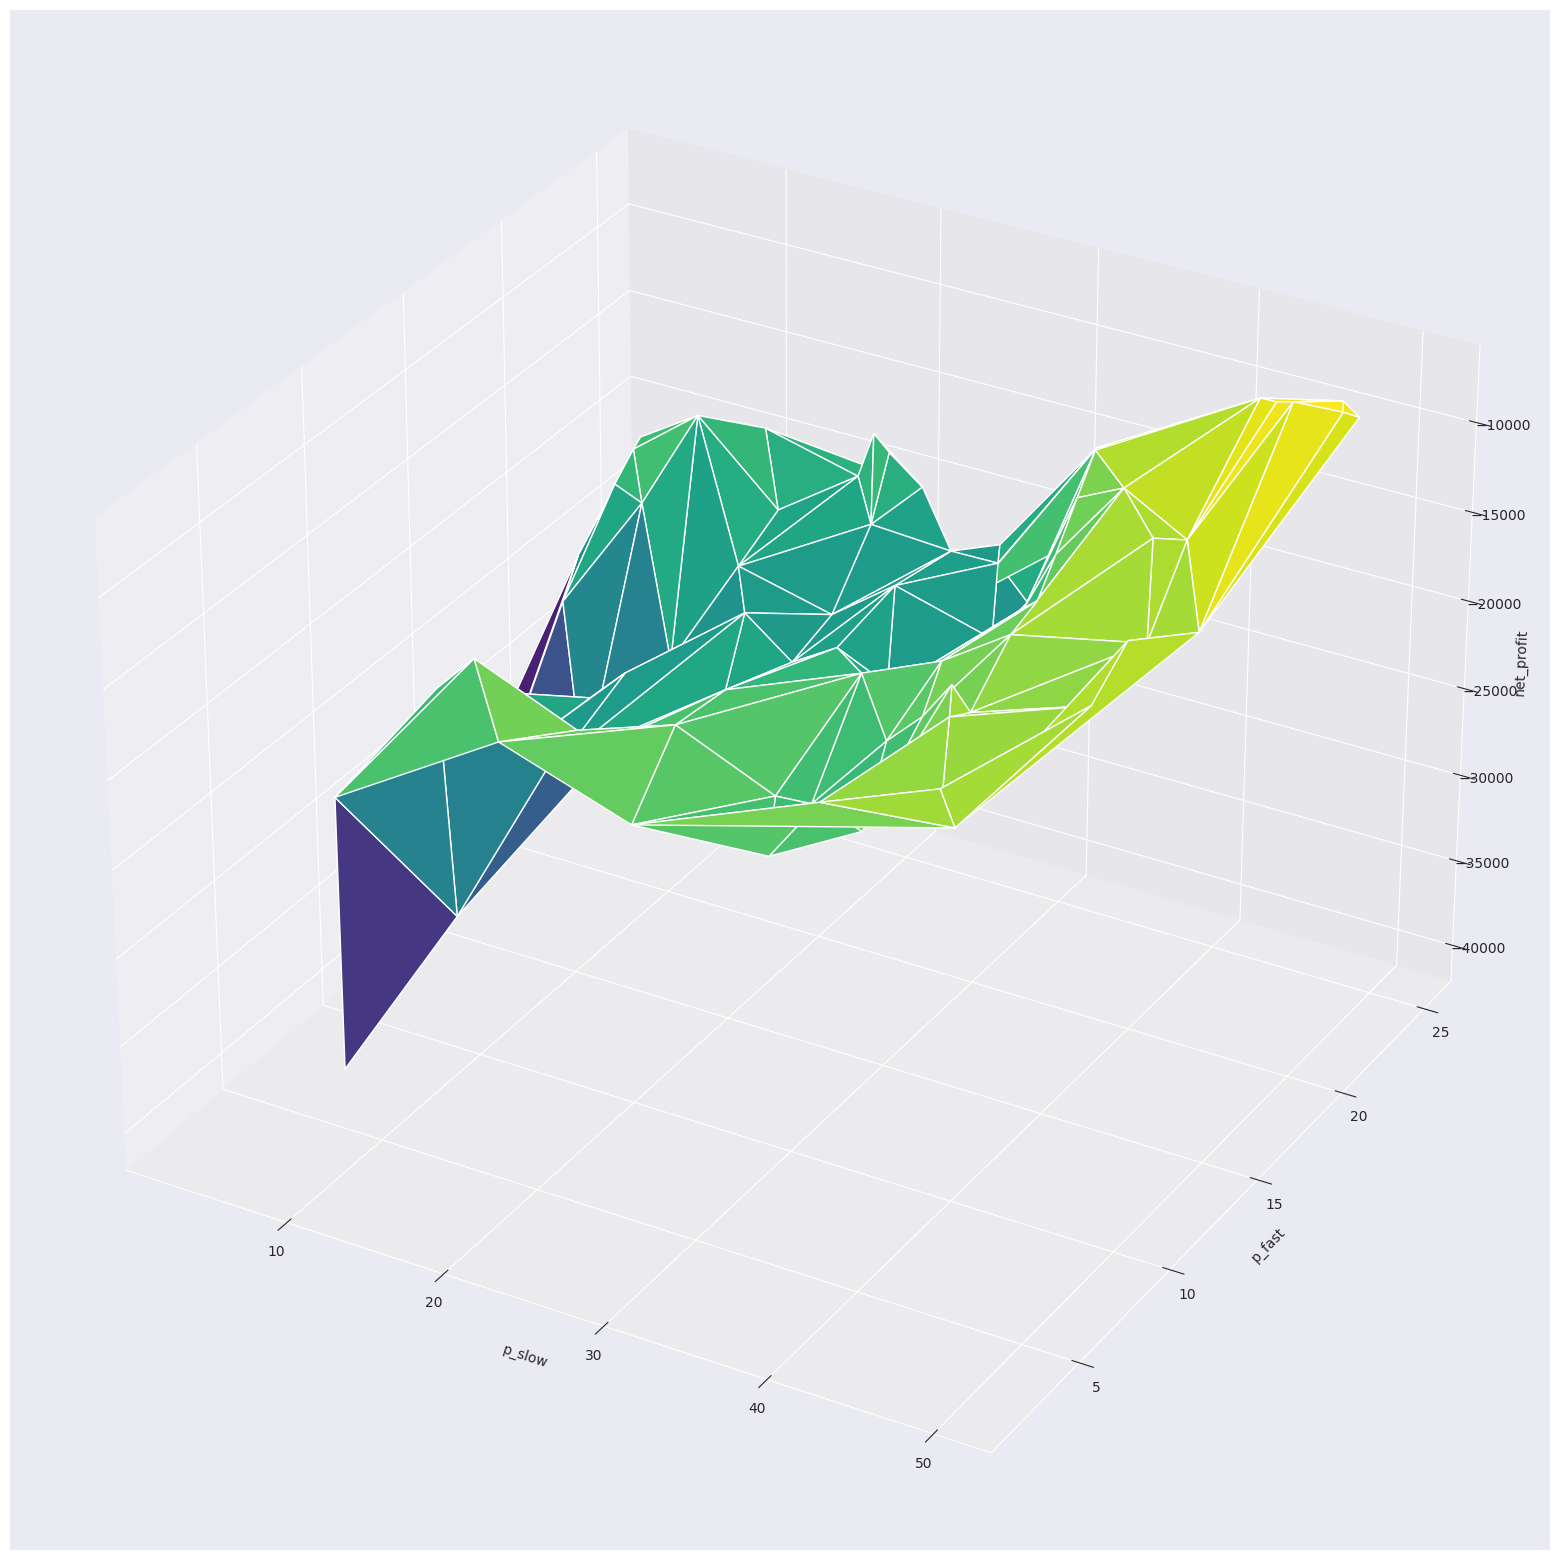

In [48]:
if  OPTIM_TYPE == 'Annealing':
    # Profit graph
    fig_plt = plt.figure(figsize=(20, 20))
    ax_plt = fig_plt.gca(projection='3d')
    surf = ax_plt.plot_trisurf(heatmap[name_x], heatmap[name_y], heatmap[OPTIM_PARAMETER], cmap='viridis', label="profit_rate")
    ax_plt.set_xlabel(name_x)
    ax_plt.set_ylabel(name_y)
    ax_plt.set_zlabel(OPTIM_PARAMETER)
    fig_plt.show()